<a href="https://colab.research.google.com/github/Quaser001/scribbles_ml/blob/main/densenet121_attention_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Cell 1 — Imports, config, manifest builder for T1 dataset

import os, glob
from pathlib import Path
import pandas as pd
import torch

# ---------------- CONFIG ----------------
# Set this to the folder that contains your T1 HC/PD folders
T1_ROOT = "/content/drive/MyDrive/xAIDataset/T1"

HC_DIR = os.path.join(T1_ROOT, "T1 HC Images")
PD_DIR = os.path.join(T1_ROOT, "T1 PD Images")
# ----------------------------------------

# Collect image files (common extensions)
exts = ('*.png','*.jpg','*.jpeg','*.tif','*.tiff','*.bmp')
def gather_files(folder):
    files = []
    for e in exts:
        files += glob.glob(os.path.join(folder, e))
    return sorted(files)

# Verify directories exist
print(f"Checking if HC directory exists: {os.path.isdir(HC_DIR)}")
print(f"Checking if PD directory exists: {os.path.isdir(PD_DIR)}")

hc_files = gather_files(HC_DIR)
pd_files = gather_files(PD_DIR)

# Verify files are found
print(f"Number of HC files found: {len(hc_files)}")
print(f"Number of PD files found: {len(pd_files)}")


rows = []
for f in hc_files:
    rows.append({
        'filepath': f,
        'label': 0,
        'label_name': 'HC',
        'filename': Path(f).name
    })
for f in pd_files:
    rows.append({
        'filepath': f,
        'label': 1,
        'label_name': 'PD',
        'filename': Path(f).name
    })

df = pd.DataFrame(rows) # Create DataFrame from the populated rows list
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# ---- Verification ----
total = len(df)
hc_count = (df.label==0).sum()
pd_count = (df.label==1).sum()

print(f"Total images found: {total}")
print(f" - HC: {hc_count}")
print(f" - PD: {pd_count}")

# class weights (for imbalance handling in CrossEntropy)
eps = 1e-8
class_freq = df['label'].value_counts().sort_index().values.astype(float)
inv_freq = 1.0 / (class_freq + eps)
class_weights = inv_freq / inv_freq.sum() * len(class_freq)
print("\nClass frequencies (label 0=HC, 1=PD):", class_freq.tolist())
print("Suggested class weights (for CrossEntropyLoss):", class_weights.tolist())

print("\nSample rows:")
print(df.head())

# Save manifest for later cells
manifest_path = "/content/drive/MyDrive/dataset_manifests/t1_manifest.csv"
os.makedirs(os.path.dirname(manifest_path), exist_ok=True)
df.to_csv(manifest_path, index=False)
print(f"\nSaved manifest to: {manifest_path}")

Checking if HC directory exists: True
Checking if PD directory exists: True
Number of HC files found: 590
Number of PD files found: 1520
Total images found: 2110
 - HC: 590
 - PD: 1520

Class frequencies (label 0=HC, 1=PD): [590.0, 1520.0]
Suggested class weights (for CrossEntropyLoss): [1.4407582938346846, 0.5592417061653152]

Sample rows:
                                            filepath  label label_name  \
0  /content/drive/MyDrive/xAIDataset/T1/T1 HC Ima...      0         HC   
1  /content/drive/MyDrive/xAIDataset/T1/T1 PD Ima...      1         PD   
2  /content/drive/MyDrive/xAIDataset/T1/T1 HC Ima...      0         HC   
3  /content/drive/MyDrive/xAIDataset/T1/T1 HC Ima...      0         HC   
4  /content/drive/MyDrive/xAIDataset/T1/T1 HC Ima...      0         HC   

                                            filename  
0  wmPPMI_3852_MR_T1-anatomical_Br_20140122155730...  
1  wmPPMI_4035_MR_T1-anatomical_Br_20141110170224...  
2  wmPPMI_3779_MR_T1-anatomical_Br_201401301539

In [5]:
import time
import copy
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as T

# ---------- Dataset Split (70 train / 20 test / 10 val) ----------
# First split off 20% for test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df['label'],
    random_state=42
)

# Then split train_val into 70% train and 10% val (0.125 of 0.80 = 0.10 total)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.125,
    stratify=train_val_df['label'],
    random_state=42
)

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")

# ---------- Custom Dataset ----------
class MRIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = Image.open(row['filepath']).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(row['label']).long()
        return img, label

# ---------- Transforms ----------
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3,1,1)),  # grayscale → 3 channels
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3,1,1)),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# ---------- Datasets ----------
train_dataset = MRIDataset(train_df, transform=train_transform)
val_dataset   = MRIDataset(val_df, transform=test_val_transform)
test_dataset  = MRIDataset(test_df, transform=test_val_transform)

# ---------- DataLoaders ----------
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# ✅ Pack into dictionary
dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}






Train size: 1477 | Val size: 211 | Test size: 422


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# --- Squeeze-and-Excitation (lightweight channel attention) ---
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y.expand_as(x)

# --- Transformer Encoder (lightweight) ---
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=512, num_heads=4, ff_dim=1024, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch, seq_len, embed_dim)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

# --- DenseNet121 + SE Attention + Transformer ---
class LightDenseTransNet(nn.Module):
    def __init__(self, num_classes=2, embed_dim=512, num_heads=4):
        super(LightDenseTransNet, self).__init__()
        # Load DenseNet121 backbone
        densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.features = densenet.features  # convolutional feature extractor
        num_ftrs = densenet.classifier.in_features  # 1024 for DenseNet121

        # Insert SE Attention after backbone
        self.se = SEBlock(num_ftrs)

        # Projection to transformer dimension
        self.proj = nn.Linear(num_ftrs, embed_dim)

        # Lightweight Transformer (1 layer)
        self.transformer = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # CNN backbone
        x = self.features(x)  # (B, 1024, H, W)
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)  # (B, 1024)

        # Apply SE Attention
        x = self.se(x.view(x.size(0), -1, 1, 1)).view(x.size(0), -1)  # still (B, 1024)

        # Project to transformer input
        x = self.proj(x).unsqueeze(1)  # (B, 1, embed_dim)

        # Transformer encoder
        x = self.transformer(x)  # (B, 1, embed_dim)
        x = x.squeeze(1)  # (B, embed_dim)

        # Classification head
        out = self.classifier(x)
        return out

# --- Test forward pass ---
if __name__ == "__main__":
    model = LightDenseTransNet(num_classes=2)
    dummy = torch.randn(4, 3, 224, 224)
    out = model(dummy)
    print("Output shape:", out.shape)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 128MB/s]


Output shape: torch.Size([4, 2])


In [7]:
# --- Training + Evaluation Module (Colab Friendly) ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import time, copy

# --- Training Loop ---
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=10, print_every=20):
    model = model.to(device)
    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())  # ✅ deepcopy

    since = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase not in dataloaders:
                continue

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects = 0.0, 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # ✅ show batch progress
                if batch_idx % print_every == 0:
                    print(f"[{phase}] Batch {batch_idx}/{len(dataloaders[phase])} - Loss: {loss.item():.4f}")

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double().item() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())  # ✅ fixed

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f}")

    model.load_state_dict(best_wts)
    return model

# --- Test Evaluation ---
def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            _, preds = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            if probs.shape[1] > 1:
                all_probs.extend(probs[:, 1].cpu().numpy())
            else:
                all_probs.extend(probs[:, 0].cpu().numpy())  # binary case fix

    # ✅ Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # ✅ Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ✅ ROC Curve
    if len(set(all_labels)) == 2:  # only for binary
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC)")
        plt.legend(loc="lower right")
        plt.show()


Device: cuda
Train samples: 1477 | Batches: 47
Val   samples: 211 | Batches: 7
Test  samples: 422 | Batches: 14
Model parameters (millions): 9.844354
Using weighted CrossEntropyLoss from `class_weights`.

Running smoke test (1 batch forward + backward)...
Smoke batch shape: torch.Size([32, 3, 224, 224]) loss: 0.7014681100845337

Starting training loop...

===== Epoch 1/10 =====


Train E1: 100%|██████████| 47/47 [02:59<00:00,  3.83s/it, batch_loss=0.7037, acc_sofar=0.5816]


Epoch 1 summary: train_loss=0.6943 train_acc=0.5911 | val_loss=0.6672 val_acc=0.3081
Epoch time: 3m 28s
New best val acc. Saving weights.

===== Epoch 2/10 =====


Train E2: 100%|██████████| 47/47 [00:21<00:00,  2.18it/s, batch_loss=0.5371, acc_sofar=0.6601]


Epoch 2 summary: train_loss=0.6041 train_acc=0.6628 | val_loss=0.4530 val_acc=0.8910
Epoch time: 0m 23s
New best val acc. Saving weights.

===== Epoch 3/10 =====


Train E3: 100%|██████████| 47/47 [00:21<00:00,  2.19it/s, batch_loss=0.2506, acc_sofar=0.8285]


Epoch 3 summary: train_loss=0.4139 train_acc=0.8294 | val_loss=0.1951 val_acc=0.9384
Epoch time: 0m 23s
New best val acc. Saving weights.

===== Epoch 4/10 =====


Train E4: 100%|██████████| 47/47 [00:21<00:00,  2.20it/s, batch_loss=0.2028, acc_sofar=0.8841]


Epoch 4 summary: train_loss=0.2717 train_acc=0.8896 | val_loss=0.1984 val_acc=0.9573
Epoch time: 0m 23s
New best val acc. Saving weights.

===== Epoch 5/10 =====


Train E5: 100%|██████████| 47/47 [00:21<00:00,  2.23it/s, batch_loss=0.2361, acc_sofar=0.9230]


Epoch 5 summary: train_loss=0.2247 train_acc=0.9215 | val_loss=0.2337 val_acc=0.9242
Epoch time: 0m 23s

===== Epoch 6/10 =====


Train E6: 100%|██████████| 47/47 [00:22<00:00,  2.08it/s, batch_loss=0.0306, acc_sofar=0.9573]


Epoch 6 summary: train_loss=0.1163 train_acc=0.9573 | val_loss=0.0916 val_acc=0.9858
Epoch time: 0m 24s
New best val acc. Saving weights.

===== Epoch 7/10 =====


Train E7: 100%|██████████| 47/47 [00:22<00:00,  2.11it/s, batch_loss=0.0922, acc_sofar=0.9741]


Epoch 7 summary: train_loss=0.0740 train_acc=0.9756 | val_loss=0.0686 val_acc=0.9905
Epoch time: 0m 24s
New best val acc. Saving weights.

===== Epoch 8/10 =====


Train E8: 100%|██████████| 47/47 [00:21<00:00,  2.21it/s, batch_loss=0.0737, acc_sofar=0.9741]


Epoch 8 summary: train_loss=0.0726 train_acc=0.9743 | val_loss=0.0717 val_acc=0.9810
Epoch time: 0m 23s

===== Epoch 9/10 =====


Train E9: 100%|██████████| 47/47 [00:21<00:00,  2.22it/s, batch_loss=0.1105, acc_sofar=0.9855]


Epoch 9 summary: train_loss=0.0507 train_acc=0.9851 | val_loss=0.0692 val_acc=0.9905
Epoch time: 0m 23s

===== Epoch 10/10 =====


Train E10: 100%|██████████| 47/47 [00:21<00:00,  2.20it/s, batch_loss=0.0124, acc_sofar=0.9886]


Epoch 10 summary: train_loss=0.0459 train_acc=0.9892 | val_loss=0.0679 val_acc=0.9858
Epoch time: 0m 23s

Training finished. Best val acc: 0.9905

Running final evaluation on test set...

--- Classification Report (test) ---
              precision    recall  f1-score   support

          HC       0.98      0.96      0.97       118
          PD       0.98      0.99      0.99       304

    accuracy                           0.98       422
   macro avg       0.98      0.98      0.98       422
weighted avg       0.98      0.98      0.98       422

Confusion matrix:
 [[113   5]
 [  2 302]]
ROC AUC = 0.9957


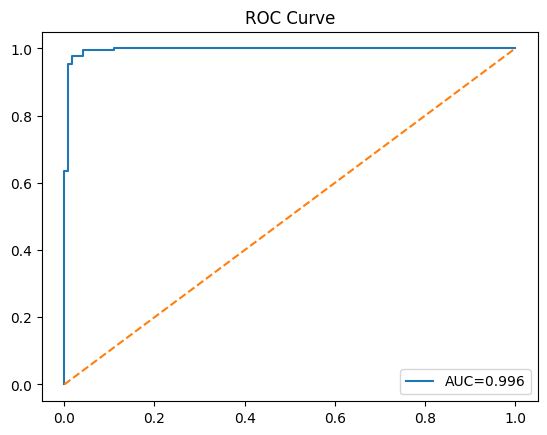

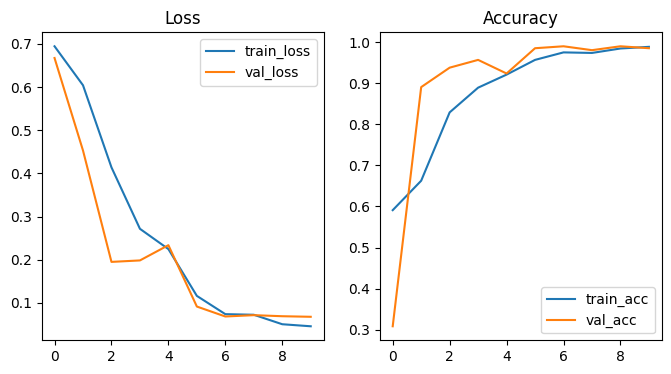


Done.


In [8]:
# ===== Debuggable Training + Evaluation Cell (paste AFTER your model + dataset cells) =====
import torch, time, copy
import torch.nn as nn, torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# ---- CONFIG (change if needed) ----
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
BATCH_SIZE = 32       # safe starting batch size for Colab; reduce to 8 or 4 if OOM
NUM_WORKERS = 0        # set to 0 in Colab to avoid deadlocks
NUM_EPOCHS = 10         # short run for debugging; increase later
PRINT_EVERY_BATCH = 20

# ---- If you already have dataloaders in memory, we'll re-create safe ones here to be sure ----
# Uses train_df/val_df/test_df from earlier cells (they are defined)
try:
    # prefer to reuse your MRIDataset class and transforms defined earlier
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
except Exception as e:
    raise RuntimeError("Could not recreate dataloaders — make sure train_dataset/val_dataset/test_dataset are defined.") from e

dataloaders = {"train": train_loader, "val": val_loader, "test": test_loader}

# ---- Sanity prints ----
print(f"Device: {DEVICE}")
print(f"Train samples: {len(train_loader.dataset)} | Batches: {len(train_loader)}")
print(f"Val   samples: {len(val_loader.dataset)} | Batches: {len(val_loader)}")
print(f"Test  samples: {len(test_loader.dataset)} | Batches: {len(test_loader)}")

# ---- Instantiate model (if not already) ----
if 'model' not in globals():
    model = LightDenseTransNet(num_classes=2).to(DEVICE)
else:
    model = model.to(DEVICE)

print("Model parameters (millions):", sum(p.numel() for p in model.parameters())/1e6)

# ---- Criterion, optimizer, scheduler ----
class_weights_tensor = None
try:
    # if class_weights from earlier exist, use them
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print("Using weighted CrossEntropyLoss from `class_weights`.")
except Exception:
    criterion = nn.CrossEntropyLoss()
    print("Using plain CrossEntropyLoss.")

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# ---- Quick smoke test: one forward + backward on a single batch ----
print("\nRunning smoke test (1 batch forward + backward)...")
model.train()
smoke_passed = False
for inputs, labels in dataloaders['train']:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print("Smoke batch shape:", inputs.shape, "loss:", loss.item())
    smoke_passed = True
    break

if not smoke_passed:
    raise RuntimeError("Smoke test could not run: dataloader gave no batches. Check dataset paths/contents.")

torch.cuda.empty_cache()
time.sleep(1)

# ---- Training loop with tqdm and debug prints ----
print("\nStarting training loop...")
best_wts = copy.deepcopy(model.state_dict())
best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")
    epoch_start = time.time()

    # --- Train phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    n_samples = 0

    pbar = tqdm(enumerate(dataloaders['train']), total=len(dataloaders['train']), desc=f"Train E{epoch+1}")
    for batch_idx, (inputs, labels) in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_n = inputs.size(0)
        running_loss += loss.item() * batch_n
        running_corrects += torch.sum(preds == labels.data).item()
        n_samples += batch_n

        if (batch_idx % PRINT_EVERY_BATCH) == 0:
            pbar.set_postfix({'batch_loss': f"{loss.item():.4f}", 'acc_sofar': f"{running_corrects/n_samples:.4f}"})

    epoch_train_loss = running_loss / n_samples
    epoch_train_acc  = running_corrects / n_samples
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    scheduler.step()  # step per epoch

    # --- Val phase ---
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_n = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            b = inputs.size(0)
            val_running_loss += loss.item() * b
            val_running_corrects += torch.sum(preds == labels.data).item()
            val_n += b

    epoch_val_loss = val_running_loss / val_n
    epoch_val_acc  = val_running_corrects / val_n
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"Epoch {epoch+1} summary: train_loss={epoch_train_loss:.4f} train_acc={epoch_train_acc:.4f} | val_loss={epoch_val_loss:.4f} val_acc={epoch_val_acc:.4f}")
    epoch_time = time.time() - epoch_start
    print(f"Epoch time: {epoch_time//60:.0f}m {epoch_time%60:.0f}s")

    # save best
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_wts = copy.deepcopy(model.state_dict())
        print("New best val acc. Saving weights.")

# load best weights
model.load_state_dict(best_wts)
print(f"\nTraining finished. Best val acc: {best_val_acc:.4f}")

# ---- Evaluate on test set (full metrics) ----
print("\nRunning final evaluation on test set...")
model.eval()
all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        probs = nn.Softmax(dim=1)(outputs)
        _, preds = torch.max(probs, 1)

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())
        # handle binary/multi-class probabilities
        if probs.shape[1] == 2:
            all_probs.extend(probs[:, 1].cpu().numpy().tolist())
        else:
            # store predicted class probability
            all_probs.extend(probs.max(dim=1)[0].cpu().numpy().tolist())

print("\n--- Classification Report (test) ---")
print(classification_report(all_labels, all_preds, target_names=["HC", "PD"]))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)

# ROC if binary
if len(set(all_labels)) == 2:
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC = {roc_auc:.4f}")
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.legend(); plt.title("ROC Curve"); plt.show()

# quick plot history
try:
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend(); plt.title("Loss")

    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.legend(); plt.title("Accuracy")
    plt.show()
except Exception as e:
    print("Could not plot history:", e)

print("\nDone.")


✅ Using weighted CrossEntropyLoss.

===== Epoch 1/25 =====


Train E1: 100%|██████████| 47/47 [00:21<00:00,  2.19it/s, batch_loss=0.8390]


train Loss: 0.7063 | Acc: 0.5504


Val E1: 100%|██████████| 7/7 [00:01<00:00,  4.29it/s, batch_loss=0.6589]


val Loss: 0.6596 | Acc: 0.7773
🎯 New best val acc. Saving weights.
Epoch time: 0m 23s

===== Epoch 2/25 =====


Train E2: 100%|██████████| 47/47 [00:21<00:00,  2.21it/s, batch_loss=0.5405]


train Loss: 0.6065 | Acc: 0.6770


Val E2: 100%|██████████| 7/7 [00:01<00:00,  4.66it/s, batch_loss=0.8083]


val Loss: 0.9842 | Acc: 0.7299
Epoch time: 0m 23s

===== Epoch 3/25 =====


Train E3: 100%|██████████| 47/47 [00:21<00:00,  2.22it/s, batch_loss=0.3395]


train Loss: 0.4413 | Acc: 0.8057


Val E3: 100%|██████████| 7/7 [00:01<00:00,  4.72it/s, batch_loss=0.4469]


val Loss: 0.4035 | Acc: 0.8815
🎯 New best val acc. Saving weights.
Epoch time: 0m 23s

===== Epoch 4/25 =====


Train E4: 100%|██████████| 47/47 [00:21<00:00,  2.21it/s, batch_loss=0.4487]


train Loss: 0.2992 | Acc: 0.8775


Val E4: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s, batch_loss=0.6579]


val Loss: 0.3408 | Acc: 0.9242
🎯 New best val acc. Saving weights.
Epoch time: 0m 23s

===== Epoch 5/25 =====


Train E5: 100%|██████████| 47/47 [00:21<00:00,  2.22it/s, batch_loss=0.0685]


train Loss: 0.2098 | Acc: 0.9248


Val E5: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s, batch_loss=0.0629]


val Loss: 0.2573 | Acc: 0.9431
🎯 New best val acc. Saving weights.
Epoch time: 0m 23s

===== Epoch 6/25 =====


Train E6: 100%|██████████| 47/47 [00:21<00:00,  2.22it/s, batch_loss=0.1554]


train Loss: 0.1756 | Acc: 0.9282


Val E6: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s, batch_loss=0.1288]


val Loss: 0.0861 | Acc: 0.9668
🎯 New best val acc. Saving weights.
Epoch time: 0m 23s

===== Epoch 7/25 =====


Train E7: 100%|██████████| 47/47 [00:21<00:00,  2.22it/s, batch_loss=0.1201]


train Loss: 0.1564 | Acc: 0.9485


Val E7: 100%|██████████| 7/7 [00:01<00:00,  4.73it/s, batch_loss=0.1816]


val Loss: 0.1561 | Acc: 0.9526
Epoch time: 0m 23s

===== Epoch 8/25 =====


Train E8: 100%|██████████| 47/47 [00:21<00:00,  2.24it/s, batch_loss=0.0781]


train Loss: 0.1666 | Acc: 0.9404


Val E8: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, batch_loss=0.0810]


val Loss: 0.1243 | Acc: 0.9763
🎯 New best val acc. Saving weights.
Epoch time: 0m 23s

===== Epoch 9/25 =====


Train E9: 100%|██████████| 47/47 [00:21<00:00,  2.23it/s, batch_loss=0.0560]


train Loss: 0.1219 | Acc: 0.9546


Val E9: 100%|██████████| 7/7 [00:01<00:00,  4.76it/s, batch_loss=0.2563]


val Loss: 0.0674 | Acc: 0.9810
🎯 New best val acc. Saving weights.
Epoch time: 0m 23s

===== Epoch 10/25 =====


Train E10: 100%|██████████| 47/47 [00:21<00:00,  2.17it/s, batch_loss=0.1183]


train Loss: 0.0938 | Acc: 0.9655


Val E10: 100%|██████████| 7/7 [00:01<00:00,  4.69it/s, batch_loss=0.0318]


val Loss: 0.2129 | Acc: 0.9526
Epoch time: 0m 23s

===== Epoch 11/25 =====


Train E11: 100%|██████████| 47/47 [00:21<00:00,  2.21it/s, batch_loss=0.0027]


train Loss: 0.0479 | Acc: 0.9844


Val E11: 100%|██████████| 7/7 [00:01<00:00,  4.70it/s, batch_loss=0.0565]


val Loss: 0.0230 | Acc: 0.9953
🎯 New best val acc. Saving weights.
Epoch time: 0m 23s

===== Epoch 12/25 =====


Train E12: 100%|██████████| 47/47 [00:21<00:00,  2.23it/s, batch_loss=0.0163]


train Loss: 0.0199 | Acc: 0.9966


Val E12: 100%|██████████| 7/7 [00:01<00:00,  4.37it/s, batch_loss=0.0019]


val Loss: 0.0304 | Acc: 0.9953
Epoch time: 0m 23s

===== Epoch 13/25 =====


Train E13: 100%|██████████| 47/47 [00:21<00:00,  2.22it/s, batch_loss=0.0651]


train Loss: 0.0174 | Acc: 0.9939


Val E13: 100%|██████████| 7/7 [00:01<00:00,  4.75it/s, batch_loss=0.0069]


val Loss: 0.0727 | Acc: 0.9858
Epoch time: 0m 23s

===== Epoch 14/25 =====


Train E14: 100%|██████████| 47/47 [00:21<00:00,  2.22it/s, batch_loss=0.0603]


train Loss: 0.0370 | Acc: 0.9851


Val E14: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s, batch_loss=0.0094]


val Loss: 0.0149 | Acc: 0.9953
Epoch time: 0m 23s

===== Epoch 15/25 =====


Train E15: 100%|██████████| 47/47 [00:21<00:00,  2.22it/s, batch_loss=0.0063]


train Loss: 0.0244 | Acc: 0.9939


Val E15: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s, batch_loss=0.0018]


val Loss: 0.0091 | Acc: 0.9953
Epoch time: 0m 23s

===== Epoch 16/25 =====


Train E16: 100%|██████████| 47/47 [00:21<00:00,  2.24it/s, batch_loss=0.0073]


train Loss: 0.0365 | Acc: 0.9878


Val E16: 100%|██████████| 7/7 [00:01<00:00,  4.64it/s, batch_loss=0.0040]


val Loss: 0.0673 | Acc: 0.9953
Epoch time: 0m 23s

===== Epoch 17/25 =====


Train E17: 100%|██████████| 47/47 [00:21<00:00,  2.20it/s, batch_loss=0.0102]


train Loss: 0.0074 | Acc: 0.9980


Val E17: 100%|██████████| 7/7 [00:01<00:00,  4.65it/s, batch_loss=0.0058]


val Loss: 0.0111 | Acc: 0.9953
Epoch time: 0m 23s

===== Epoch 18/25 =====


Train E18: 100%|██████████| 47/47 [00:21<00:00,  2.21it/s, batch_loss=0.0190]


train Loss: 0.0493 | Acc: 0.9865


Val E18: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s, batch_loss=0.0169]


val Loss: 0.1312 | Acc: 0.9858
Epoch time: 0m 23s

===== Epoch 19/25 =====


Train E19: 100%|██████████| 47/47 [00:21<00:00,  2.23it/s, batch_loss=0.0081]


train Loss: 0.0541 | Acc: 0.9817


Val E19: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s, batch_loss=0.0525]


val Loss: 0.0178 | Acc: 0.9905
Epoch time: 0m 23s

===== Epoch 20/25 =====


Train E20: 100%|██████████| 47/47 [00:21<00:00,  2.23it/s, batch_loss=0.0009]


train Loss: 0.0188 | Acc: 0.9953


Val E20: 100%|██████████| 7/7 [00:01<00:00,  4.72it/s, batch_loss=0.0047]


val Loss: 0.0436 | Acc: 0.9953
Epoch time: 0m 23s

===== Epoch 21/25 =====


Train E21: 100%|██████████| 47/47 [00:21<00:00,  2.23it/s, batch_loss=0.0028]


train Loss: 0.0098 | Acc: 0.9973


Val E21: 100%|██████████| 7/7 [00:01<00:00,  4.75it/s, batch_loss=0.0027]


val Loss: 0.0275 | Acc: 0.9953
Epoch time: 0m 23s

===== Epoch 22/25 =====


Train E22: 100%|██████████| 47/47 [00:21<00:00,  2.22it/s, batch_loss=0.0019]


train Loss: 0.0164 | Acc: 0.9932


Val E22: 100%|██████████| 7/7 [00:01<00:00,  4.79it/s, batch_loss=0.0024]


val Loss: 0.0369 | Acc: 0.9953
Epoch time: 0m 23s

===== Epoch 23/25 =====


Train E23: 100%|██████████| 47/47 [00:21<00:00,  2.22it/s, batch_loss=0.0006]


train Loss: 0.0075 | Acc: 0.9966


Val E23: 100%|██████████| 7/7 [00:01<00:00,  3.82it/s, batch_loss=0.0004]


val Loss: 0.0213 | Acc: 0.9953
Epoch time: 0m 23s

===== Epoch 24/25 =====


Train E24: 100%|██████████| 47/47 [00:21<00:00,  2.23it/s, batch_loss=0.0019]


train Loss: 0.0200 | Acc: 0.9946


Val E24: 100%|██████████| 7/7 [00:01<00:00,  4.71it/s, batch_loss=0.0009]


val Loss: 0.0457 | Acc: 0.9953
Epoch time: 0m 23s

===== Epoch 25/25 =====


Train E25: 100%|██████████| 47/47 [00:21<00:00,  2.22it/s, batch_loss=0.0074]


train Loss: 0.0115 | Acc: 0.9953


Val E25: 100%|██████████| 7/7 [00:01<00:00,  4.65it/s, batch_loss=0.0017]


val Loss: 0.0422 | Acc: 0.9953
Epoch time: 0m 23s

✅ Training finished. Best val acc: 0.9953


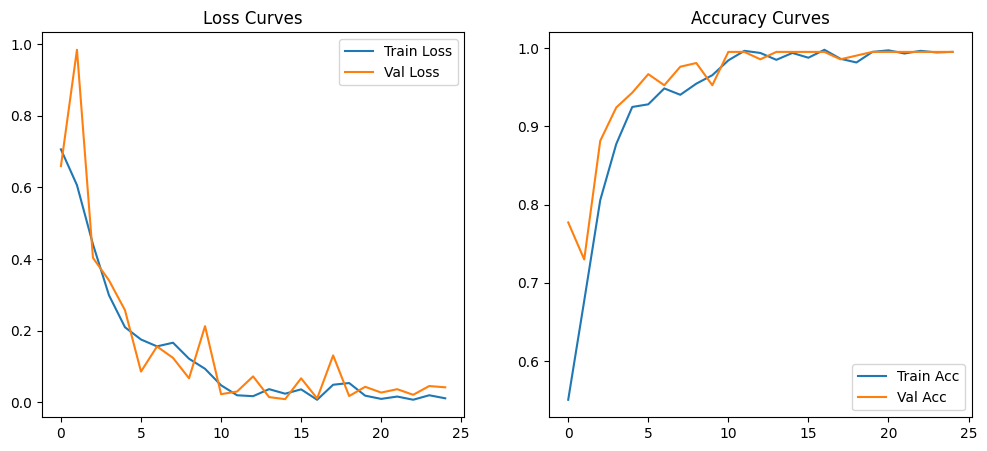


🔎 Final evaluation on test set...

Test Accuracy: 0.9929
Precision: 0.9902 | Recall/Sensitivity: 1.0000 | Specificity: 0.9746 | F1 Score: 0.9951

--- Classification Report ---
              precision    recall  f1-score   support

          HC       1.00      0.97      0.99       118
          PD       0.99      1.00      1.00       304

    accuracy                           0.99       422
   macro avg       1.00      0.99      0.99       422
weighted avg       0.99      0.99      0.99       422



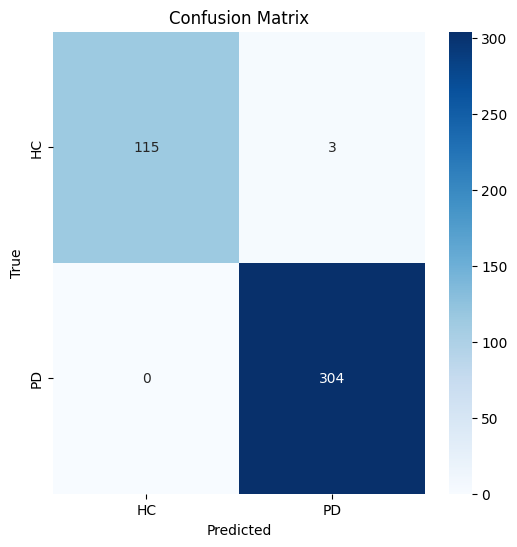

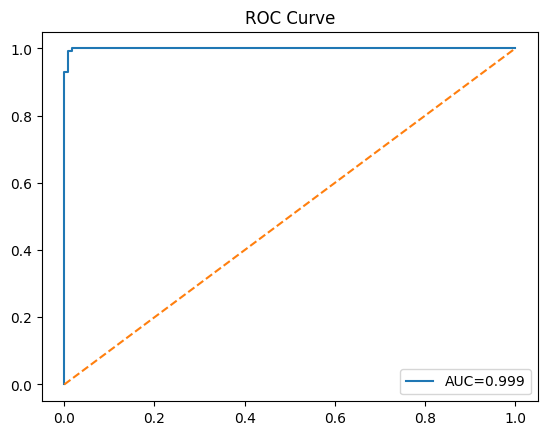

In [9]:
# ===== Extended Training + Evaluation Module =====
import torch, time, copy
import torch.nn as nn, torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_score, recall_score,
                             f1_score, accuracy_score)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# ---- CONFIG ----
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 25          # 🔥 increase epochs
PRINT_EVERY_BATCH = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# ---- DataLoaders (reuse from your MRIDataset) ----
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
dataloaders = {"train": train_loader, "val": val_loader, "test": test_loader}

# ---- Model ----
model = LightDenseTransNet(num_classes=2).to(DEVICE)

# ---- Loss + Optimizer ----
try:
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print("✅ Using weighted CrossEntropyLoss.")
except:
    criterion = nn.CrossEntropyLoss()
    print("⚠️ Using plain CrossEntropyLoss.")

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ---- Train + Validation Loop ----
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_wts = copy.deepcopy(model.state_dict())
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")
    epoch_start = time.time()

    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss, running_corrects, n_samples = 0.0, 0, 0

        pbar = tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase]), desc=f"{phase.capitalize()} E{epoch+1}")
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels.data).item()
            n_samples += batch_size

            if batch_idx % PRINT_EVERY_BATCH == 0:
                pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

        epoch_loss = running_loss / n_samples
        epoch_acc = running_corrects / n_samples
        history[f"{phase}_loss"].append(epoch_loss)
        history[f"{phase}_acc"].append(epoch_acc)

        print(f"{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

        if phase == "val" and epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            best_wts = copy.deepcopy(model.state_dict())
            print("🎯 New best val acc. Saving weights.")

    scheduler.step()
    print(f"Epoch time: {(time.time()-epoch_start)//60:.0f}m {(time.time()-epoch_start)%60:.0f}s")

# Load best weights
model.load_state_dict(best_wts)
print(f"\n✅ Training finished. Best val acc: {best_val_acc:.4f}")

# ---- Plot Train/Val Curves ----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title("Accuracy Curves")
plt.show()

# ---- Final Test Evaluation ----
print("\n🔎 Final evaluation on test set...")
model.eval()
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        probs = nn.Softmax(dim=1)(outputs)
        _, preds = torch.max(probs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:,1].cpu().numpy())  # prob of PD class

# ---- Metrics ----
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec  = recall_score(all_labels, all_preds)   # sensitivity
f1   = f1_score(all_labels, all_preds)
spec = recall_score(all_labels, all_preds, pos_label=0)  # specificity

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f} | Recall/Sensitivity: {rec:.4f} | Specificity: {spec:.4f} | F1 Score: {f1:.4f}")

print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=["HC","PD"]))

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HC","PD"], yticklabels=["HC","PD"])
plt.title("Confusion Matrix"); plt.ylabel("True"); plt.xlabel("Predicted")
plt.show()

# ---- ROC Curve ----
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.legend(); plt.title("ROC Curve"); plt.show()


In [10]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=fd0981f8417b0c996b681feaf52614ecdcd64f5c42248717fb88977d4485fe0b
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [11]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image


In [12]:
target_layers = [model.features[-1]]  # last DenseNet block conv output


In [24]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

def visualize_gradcam_pp(model, dataloader, device, target_layers, class_names, num_images=4):
    model.eval()
    # ✅ remove use_cuda, new API handles device automatically
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

    shown = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        grayscale_cams = cam(input_tensor=inputs)  # (B,H,W)

        for i in range(inputs.size(0)):
            if shown >= num_images:
                return
            img = inputs[i].detach().cpu().permute(1,2,0).numpy()
            img = (img - img.min()) / (img.max() - img.min())  # normalize [0,1]
            grayscale_cam = grayscale_cams[i, :]
            visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

            plt.figure(figsize=(6,3))
            plt.subplot(1,2,1)
            plt.imshow(img)
            plt.title(f"Original - {class_names[labels[i]]}")
            plt.axis("off")

            plt.subplot(1,2,2)
            plt.imshow(visualization)
            plt.title("Grad-CAM++ Heatmap")
            plt.axis("off")
            plt.show()

            shown += 1


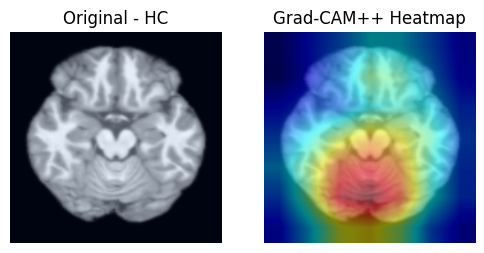

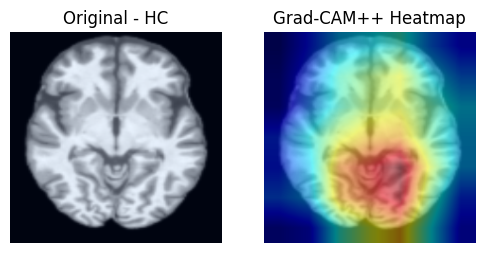

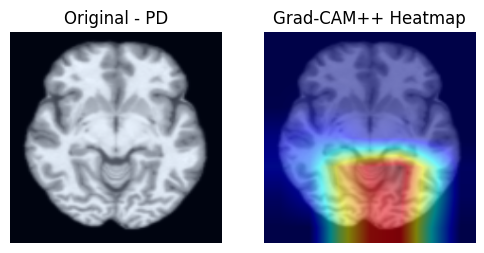

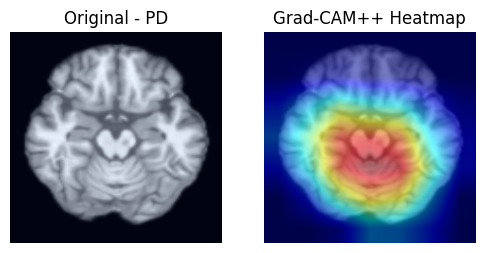

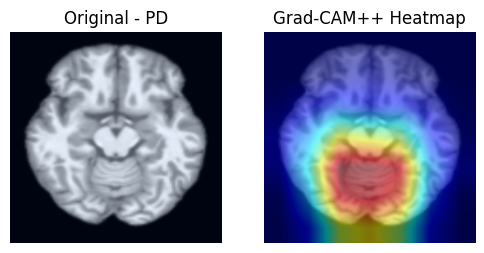

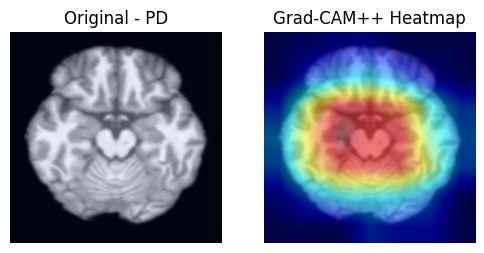

In [25]:
# For DenseNet-based model
target_layers = [model.features[-1]]

visualize_gradcam_pp(
    model,
    dataloaders["test"],
    DEVICE,
    target_layers,
    class_names=["HC","PD"],
    num_images=6
)


In [34]:
# --- SHAP Explanations for DenseNet+Attention ---
import shap
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_shap_explanations(model, dataloader, device, class_names, num_images=4):
    """
    Visualize SHAP explanations for model predictions on MRI images.

    Args:
        model: trained torch model
        dataloader: torch dataloader (test or validation set)
        device: 'cuda' or 'cpu'
        class_names: list of class names
        num_images: number of samples to visualize
    """
    model.eval()

    # 1) Get a batch from dataloader
    inputs, labels = next(iter(dataloader))
    inputs, labels = inputs.to(device), labels.to(device)

    # Pick only num_images
    inputs = inputs[:num_images]
    labels = labels[:num_images]

    # 2) Define SHAP GradientExplainer
    explainer = shap.GradientExplainer(model, inputs)

    # 3) Compute SHAP values for all classes
    shap_values, indexes = explainer.shap_values(inputs, ranked_outputs=2, output_rank_order="max")

    # 4) Plot explanations
    for i in range(num_images):
        true_label = class_names[labels[i].item()]
        pred_class = class_names[indexes[i][0].item()]

        # Convert tensor -> numpy image
        img = inputs[i].detach().cpu().numpy().transpose(1,2,0)
        img = (img - img.min()) / (img.max() - img.min())  # normalize for display

        # SHAP value for predicted class
        shap_pred = shap_values[indexes[i][0].item()][i].mean(axis=0)

        # SHAP value for ground truth class
        shap_true = shap_values[labels[i].item()][i].mean(axis=0)

        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow(img)
        axs[0].set_title(f"Original\nTrue: {true_label}\nPred: {pred_class}")
        axs[0].axis("off")

        axs[1].imshow(img)
        axs[1].imshow(shap_pred, cmap="jet", alpha=0.5)
        axs[1].set_title("SHAP - Predicted Class")
        axs[1].axis("off")

        axs[2].imshow(img)
        axs[2].imshow(shap_true, cmap="jet", alpha=0.5)
        axs[2].set_title("SHAP - Ground Truth Class")
        axs[2].axis("off")

        plt.show()


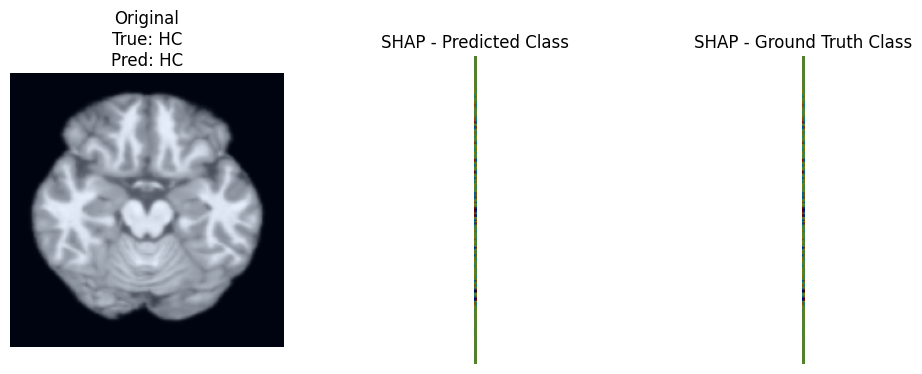

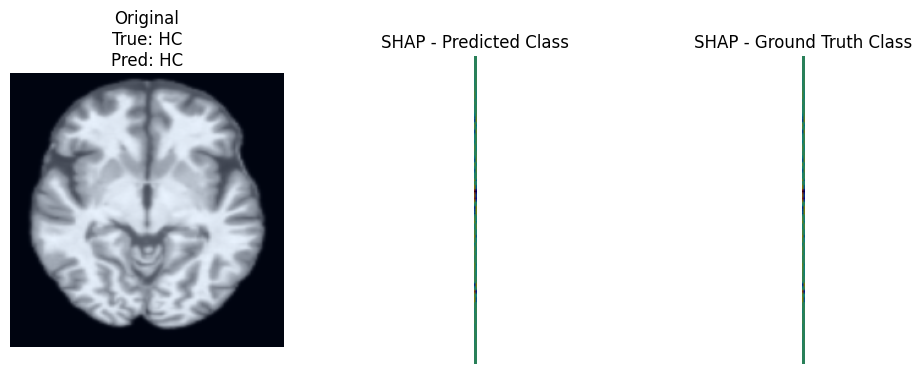

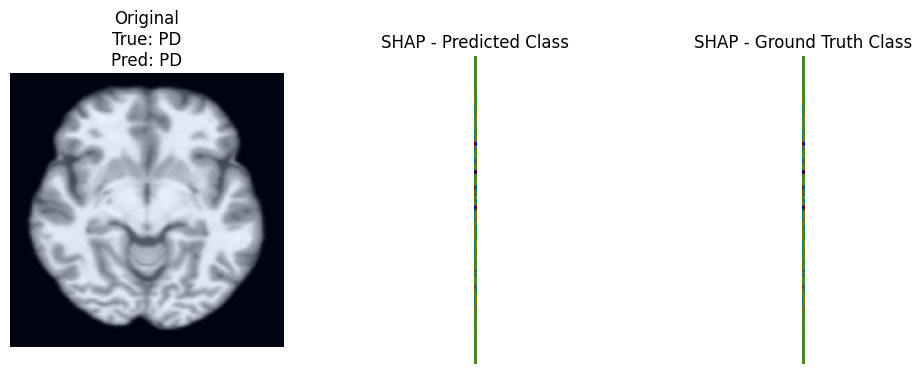

IndexError: index 3 is out of bounds for axis 0 with size 3

In [35]:
# Run SHAP visualization on test set
visualize_shap_explanations(
    model,
    dataloaders["test"],   # or "val"
    device=DEVICE,
    class_names=["HC","PD"],
    num_images=6
)
